# schNell

This notebook takes you through the basics of how to use `schNell`.

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import healpy as hp
import schnell as snl

The two main components of `schNell` are `Detector`s and `MapCalculator`s. Let's examine each of them in turn.

## 1. Detectors

`schNell` currently supports 3 types of detectors, all of which inherit from the `Detector` superclass:

- `GroundDetector` objects represent individual 2-arm detectors with fixed positions in Earth coordinates, which therefore rotate and scan with the Earth's motion.
- `GroundDetectorTriangle` objects represent ground-based detectors in triangular configurations (i.e. you will normally spawn three of these together representing the triangle configuration.
- `LISADetector` objects represent LISA-like detectors. I.e. triangular configurations that orbit the Sun on interlacing elliptical orbits.

Let's create some of these

In [3]:
# Two detectors for Hanford and Livignstone.
# These are defined by their Earth coordinates, orientation angle
# and noise PSD (which we read from a file).
hf = snl.GroundDetector('Hanford', 46.4, -119.4, 171.8, '../plots/data/aLIGO.txt')
lv = snl.GroundDetector('Livingstone', 30.7, -90.8, 243.0, '../plots/data/aLIGO.txt')

# A trio of detectors representing the Einstein Telescope
et = [snl.GroundDetectorTriangle(name='ET%d' % i, lat=40.1, lon=9.0,
                                 fname_psd='../plots/data/ET.txt', detector_id=i)
      for i in range(3)]

# A trio of detectors representing the LISA spacecraft
lisa = [snl.LISADetector(i) for i in range(3)]


### 1.1 Positions
You can track the positions of the different detectors in their natural coordinates. For instance, let's look at the LISA orbits.

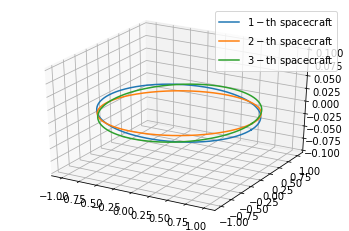

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# First lets get the spacecraft positions throughout the year
t_arr = np.linspace(0, 365*24*3600, 1024)
pos_lisa = np.array([l.get_position(t_arr) for l in lisa])

# Now let's plot them
from mpl_toolkits.mplot3d import Axes3D

# We'll plot things in units of 1 A.U.
R_AU = lisa[0].R_AU

fig = plt.figure()
ax = fig.gca(projection='3d')
for ip, p in enumerate(pos_lisa):
    ax.plot(p[0] / R_AU, p[1] / R_AU, p[2] / R_AU,
            label=r'${\rm %d-th\,\,spacecraft}$' % (ip+1))
ax.set_zlim([-0.1, 0.1])
ax.legend();

You can use those positions to check out the effects of breathing on the arm lenghts and angles

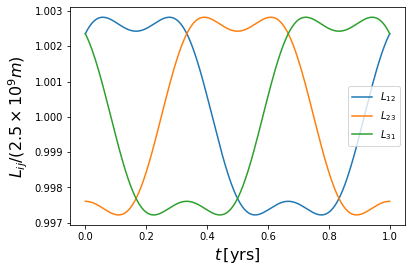

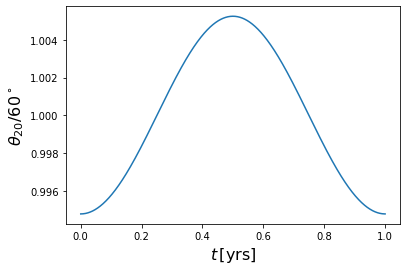

In [5]:
# Relative positions
dx01 = pos_lisa[1]-pos_lisa[0]
dx12 = pos_lisa[2]-pos_lisa[1]
dx20 = pos_lisa[0]-pos_lisa[2]

# Lengths
yr = 365*24*3600
plt.figure()
plt.plot(t_arr / yr, np.sqrt(np.sum(dx01**2, axis=0))/2.5E9, label=r'$L_{12}$')
plt.plot(t_arr / yr, np.sqrt(np.sum(dx12**2, axis=0))/2.5E9, label=r'$L_{23}$')
plt.plot(t_arr / yr, np.sqrt(np.sum(dx20**2, axis=0))/2.5E9, label=r'$L_{31}$')
plt.xlabel(r'$t\,[{\rm yrs}]$', fontsize=16)
plt.ylabel(r'$L_{ij} / (2.5\times 10^9 m)$', fontsize=16)
plt.legend();

# Angles
l01 = np.sqrt(np.sum(dx01**2, axis=0))
l20 = np.sqrt(np.sum(dx20**2, axis=0))
theta = np.arccos(np.sum(dx01 * (-dx20), axis=0)/(l01 * l20))
theta *= 3/ np.pi
plt.figure()
plt.plot(t_arr / yr, theta)
plt.xlabel(r'$t\,[{\rm yrs}]$', fontsize=16)
plt.ylabel(r'$\theta_{20} / 60^\circ$', fontsize=16);


### 1.2 Arms
We can also track the motion of the detector arms. Let's look at what one of the LISA vertices is doing throughout the year.

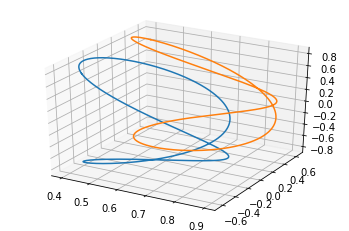

In [6]:
u, v = lisa[0].get_u_v(t_arr)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(u[0], u[1], u[2], label='Arm 1')
ax.plot(v[0], v[1], v[2], label='Arm 2');

### 1.3 PSDs
All detectors also carry their own noise PSDs

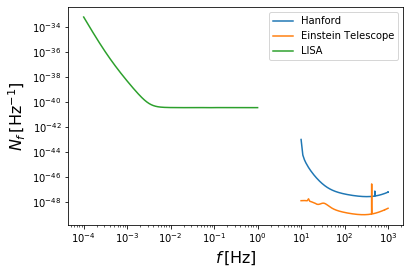

In [7]:
# High frequencies for the Earth-based detectors
f_hi = np.linspace(10, 1000, 1024)
n_hf = hf.psd(f_hi)
n_et = et[0].psd(f_hi)

# Low frequencies for LISA
f_lo = np.geomspace(1E-4, 1, 1024)
n_lisa = lisa[0].psd(f_lo)

# Plot!
plt.figure()
plt.plot(f_hi, n_hf, label='Hanford')
plt.plot(f_hi, n_et, label='Einstein Telescope')
plt.plot(f_lo, n_lisa, label='LISA')
plt.loglog()
plt.legend()
plt.xlabel(r'$f\,[{\rm Hz}]$', fontsize=16)
plt.ylabel(r'$N_f\,[{\rm Hz}^{-1}]$', fontsize=16);


## 2. MapCalculators
Map calculators compute map-level noise quantities for a network of detectors. Let's compute a few basic quantities for the Hanford-Livingstone baseline.

In [8]:
# We will use a pivot frequency of 63 Hz and a spectral index of 2/3,
# corresponding to a stochastic background of binary mergers.
mc = snl.MapCalculator([hf, lv], f_pivot=63., spectral_index=2./3.)

## 2.1 Antenna patterns
Let's start by looking at the antenna patern for this 2-element network. We will sample it on a HEALPix map with resolution parameter `nside=64` (corresponding to degree-sized pixels).

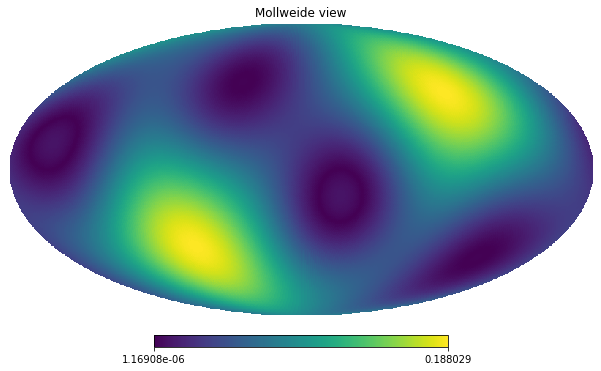

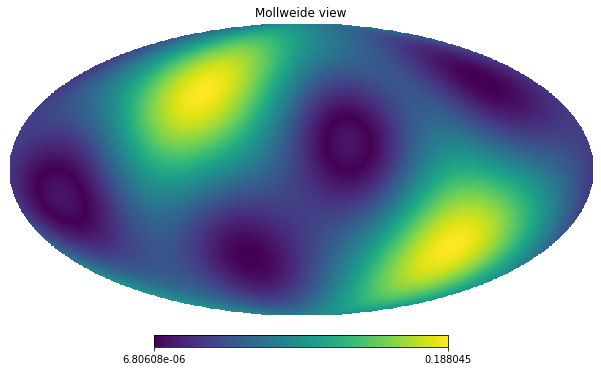

In [9]:
# First, we compute the coordinates for each pixel in the map
nside = 64
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))

# Let's compute the antenna pattern at the start of the day and in the middle of it.
# We'll do it at a fixed frequency of 40 GHz
# i and j here are the indices of the two detectors we are correlating
antenna_start = np.abs(mc.get_antenna(i=0, j=1, t=0., f=40.,
                                      theta=theta, phi=phi))
antenna_mid = np.abs(mc.get_antenna(i=0, j=1, t=12 * 3500, f=40.,
                                    theta=theta, phi=phi))

# Plot!
hp.mollview(antenna_start)
hp.mollview(antenna_mid)
plt.show()

### 2.2 Inverse noise variance maps
You can also compute the inverse-noise variance map for a given timeframe. If you want to e.g. compute the map at the end of an observing season, compute it at a set of timeframes and then add them! The map will be integrated over frequencies with the assumed spectral index.

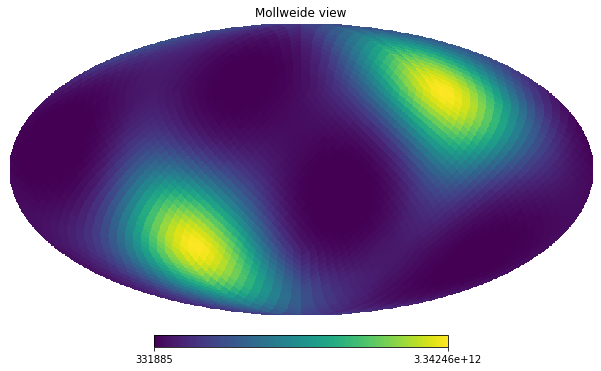

In [10]:
# We're gonna use a lower nside here, since this calculation can be a bit lengthy
nside = 16
inoi_hl = mc.get_Ninv_t(t=0., f=f_hi, nside=nside, no_autos=True)
# By using no-autos above, we make sure that we don't include any detector auto-correlations

# Plotting time!
hp.mollview(inoi_hl)

### 2.3 Noise power spectra
OK, now, the quantity that `schNell` is named after. The noise power spectrum $N_\ell$. We'll compute it assuming one full year of observation

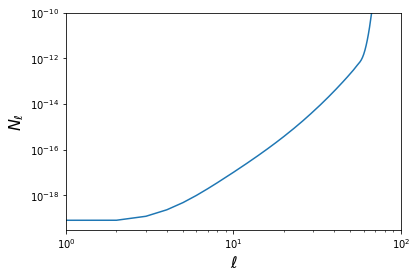

In [11]:
nside = 64
obs_time = 365 * 24 * 3600
freqs = np.linspace(10., 1010., 101)

nl = mc.get_N_ell(obs_time, freqs, nside, no_autos=True)

# Plotting time!
ls = np.arange(3 * nside)
plt.figure()
plt.plot(ls, nl)
plt.xlim([1, 100])
plt.ylim([3E-20, 1E-10])
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$N_\ell$', fontsize=16)
plt.loglog();


### 2.4 The monopole
Finally, we can also use `schNell` to study the monopole, by computing the so-called power-law-integrated sensitivity curves. Here's what it looks like for the Hanford-Livingstone arm.

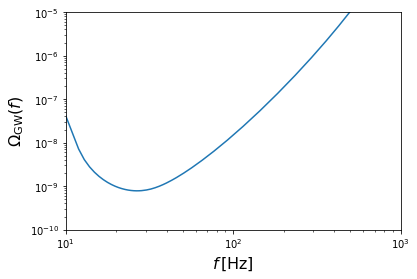

In [12]:
nside = 16
pi = mc.get_pi_curve(obs_time, f_hi, nside,
                     no_autos=True, nsigma=2)

# Plotting!
plt.plot(f_hi, pi)
plt.xlabel(r'$f\,[{\rm Hz}]$', fontsize=16)
plt.ylabel(r'$\Omega_{\rm GW}(f)$', fontsize=16)
plt.xlim([10, 1000])
plt.ylim([1E-10, 1E-5])
plt.loglog();